# Tutorial 2: Swendsen-Wang Algorithm

In [1]:
import numpy as np
from scipy import constants, sparse
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numba import jit

plt.style.use("dark_background")

In [2]:
def index1D(L_y, x, y):
    return x * L_y + y

def index2D(L_y, n):
    return n // L_y, n % L_y


In [3]:
# a)

def get_bond_array(L_x, L_y):
    nodes = np.arange(L_x * L_y)
    bonds = []

    for n in nodes:
        x,y = index2D(L_y, n)
        x_neighbour = (x+1) % L_x
        y_neighbour = (y+1) % L_y
        bonds.append([n, index1D(L_y, x, y_neighbour)])
        bonds.append([n, index1D(L_y, x_neighbour, y)])

    return np.array(bonds, dtype=int)

In [4]:
L_x = 5 #side length of lattice
L_y = 5

bonds = get_bond_array(L_x, L_y)

In [5]:
# b)

L_x = 5
L_y = 5
N = L_x*L_y
bonds = get_bond_array(L_x, L_y)
spins = np.random.randint(0, 2, size=N) * 2 - 1


In [6]:
# c)

def assign_weights(bonds, spins, J=1, T=4.2):
    w_bs = []
    for b in bonds:
        s1 = spins[b[0]]
        s2 = spins[b[1]]

        w_b=1

        if s1*s2 == -1:
            w_b=0
        elif np.exp(-2.*J/T) > np.random.rand():
            w_b=0

        w_bs.append(w_b)
    return w_bs

In [7]:
# d)
L_x = 5
L_y = 5

spins = np.random.randint(0, 2, size=L_x * L_y) * 2 - 1
bonds = get_bond_array(L_x, L_y)


def flip_cluster(spins, bonds, L_x, L_y, T):
    N = L_x * L_y
    weights = assign_weights(bonds, spins, T)

    graph = sparse.csr_matrix((weights, (bonds[:,0], bonds[:,1])), shape=(N,N))
    graph_combined = graph+graph.T

    cluster_cnt, cluster_labels = sparse.csgraph.connected_components(graph_combined, directed=False)

   # flipping the actual clusters
    for cluster in range(1,cluster_cnt):
        if np.random.rand() > 0.5:
            spins[cluster_labels == cluster] *= -1

    # flipping the single member clusters
    for idx in range(len(spins)):
        if not cluster_labels[idx]:
            if np.random.rand() > 0.5:
                spins[idx] *= -1

    return spins

In [8]:
# e)
def system_energy(spins, bonds, J=1):
    return J * np.sum(spins[bonds[:,0]]*spins[bonds[:,1]])


def system_magnetization(spins):
    return np.sum(spins)

E = system_energy(spins, bonds)
M = system_magnetization(spins)


In [9]:
#f)


def run_mc(T, L_x=6, L_y=6):

    spins = np.random.randint(0, 2, size=L_x * L_y) * 2 - 1
    bonds = get_bond_array(L_x, L_y)

    N_eq = 500
    N_flips = 2000
    N_sweeps = 20

    Es = [] # energies
    Ms = [] # magnetizations
    Iterations = []

    for i in tqdm(range(N_flips)):
        flip_cluster(spins, bonds, L_x, L_y, T)

        if i < N_eq:
            continue

        if N_flips % N_sweeps == 0:
            Es.append(system_energy(spins, bonds))
            Ms.append(system_magnetization(spins))
            Iterations.append(i)



    return np.mean(Es), np.mean(Ms), len(Es)


def run_temperatures(Ts):
    Es = []
    Ms = []

    for T in Ts:
        #print("Running temperature {}".format(T))
        E, M, cnt = run_mc(T)
        Es.append(E)
        Ms.append(M)


    return Ts, Es, Ms, cnt


def make_plots(Ts, Es, Ms):
    plt.plot(Ts, Es, "-o", label="Energy mean over {} measurements".format(cnt))
    plt.xlabel("Temperature")
    plt.ylabel("Energy")

    plt.figure()
    plt.plot(Ts, Ms, "-o", label="Magnetization mean over {} measurements".format(cnt))

    plt.xlabel("Temperature")
    plt.ylabel("Magentization")

    plt.show()


In [10]:
Ts = np.arange(0.5, 2.5, 0.2)
Ts, Es, Ms, cnt = run_temperatures(Ts)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

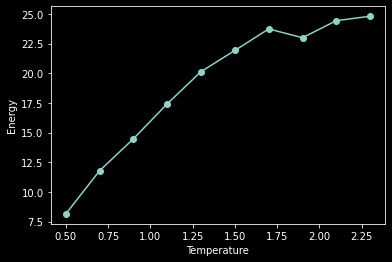

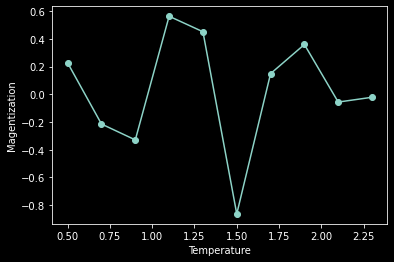

In [125]:
make_plots(Ts, Es, Ms)

In [ ]:
Ts = np.arange(1.7, 2.7, .05)
Ts, Es, Ms, cnt = run_temperatures(Ts)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

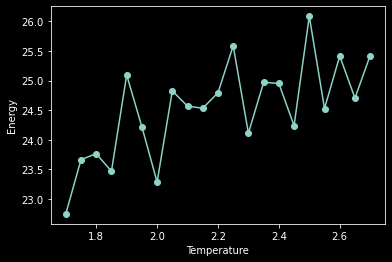

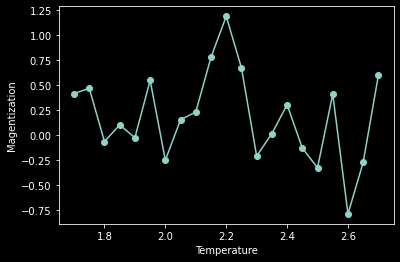

In [127]:
make_plots(Ts, Es, Ms)